# EIT-binary
This is an example file explaining how to work with the EIT-binary package. Data is loaded from an example file. 

Data is loaded as a sequence of consecutive frames.
A sequence can consist of an entire measurement or be split up as separate sections of a measurement.

In [3]:
from eitprocessing.binreader import Sequence

path = "path/to/testdata.bin"
measurement = Sequence.from_path(path=path, vendor="draeger", sample_frequency=20)

A sequence can be sliced to select a subset of frames.

In [4]:
short_section = measurement[6883:7300]

A sequence contains information about the entire measurement and/or the selected section: the number of frames, which framesets are available, the time range, path to the source file, and sample frequency. 
Some attributes are hidden when printing to preserve screen space.

In [5]:
import numpy as np

np.set_printoptions(threshold=0)  # prevents printing of the entire time array

from pprint import pprint

pprint(measurement)
pprint(short_section)

Sequence(path=PosixPath('/home/dbodor/git/EIT-ALIVE/eitprocessing/eitprocessing/binreader/testdata/Testdata_PEEPtrial.bin'),
         time=array([0.00000e+00, 5.00000e-02, 1.00000e-01, ..., 1.38385e+03,
       1.38390e+03, 1.38395e+03]),
         n_frames=27680,
         framerate=20,
         framesets={'raw': Frameset(name='raw',
                                    description='raw impedance data',
                                    params={'framerate': 20})})
Sequence(path=PosixPath('/home/dbodor/git/EIT-ALIVE/eitprocessing/eitprocessing/binreader/testdata/Testdata_PEEPtrial.bin'),
         time=array([344.15, 344.2 , 344.25, ..., 364.85, 364.9 , 364.95]),
         n_frames=417,
         framerate=20,
         framesets={'raw': Frameset(name='raw',
                                    description='raw impedance data',
                                    params={'framerate': 20})})


## Framesets

Data is contained within framesets.
A frameset contains data that has been processed or edited in some way. 
By default, loaded data only contains raw impedance data, without any processing.

Impedance data is available as the `pixel_values` attribute, which is a `np.ndarray` with three dimensions: time, rows, columns.

In [6]:
pprint(short_section.framesets["raw"])
print("shape:", short_section.framesets["raw"].pixel_values.shape, "=> (index, row, colum)")

Frameset(name='raw', description='raw impedance data', params={'framerate': 20})
shape: (417, 32, 32) => (index, row, colum)


You can deepcopy a frameset to create differently processed framesets.
Deepcopying prevents sharing mutable attributes, e.g. the `params` dict.
The example below uses the `Framset.pixel_baseline` property, which contains the lowest value per pixel over all frames in the sequence.

In [7]:
bc = short_section.framesets["raw"].deepcopy()
bc.name = "baseline_corrected"
bc.description = "raw data with a baseline correction for this section"
bc.pixel_values = bc.pixel_values - bc.pixel_baseline
bc.params.update({"pre-processing": "pixel baseline correction"})
short_section.framesets["bc"] = bc

pprint(short_section.framesets)

{'bc': Frameset(name='baseline_corrected',
                description='raw data with a baseline correction for this '
                            'section',
                params={'framerate': 20,
                        'pre-processing': 'pixel baseline correction'}),
 'raw': Frameset(name='raw',
                 description='raw impedance data',
                 params={'framerate': 20})}


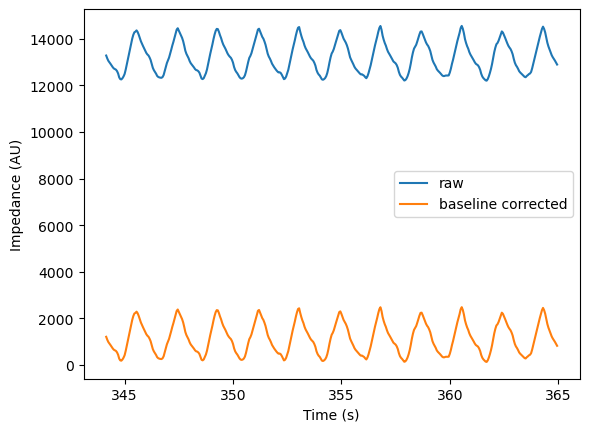

In [8]:
from matplotlib import pyplot as plt

plt.plot(short_section.time, short_section.framesets["raw"].global_impedance, label="raw")
plt.plot(short_section.time, short_section.framesets["bc"].global_impedance, label="baseline corrected")
plt.xlabel("Time (s)")
plt.ylabel("Impedance (AU)")
plt.legend()

## Pixel data

Pixel impedance data can be accessed by indexing pixel_values by row and column numbers. 
Both are zero-indexed, with (0, 0) being the top left of the image (anterior right of the subject).

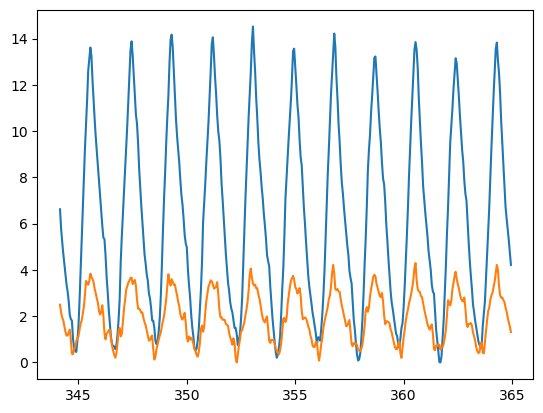

In [9]:
pixel_A = short_section.framesets["bc"].pixel_values[:, 17, 10]
pixel_B = short_section.framesets["bc"].pixel_values[:, 12, 20]

plt.plot(short_section.time, pixel_A)
plt.plot(short_section.time, pixel_B)

## Events

If a sequence contains events, they are loaded and available in the `events` attribute.

[Event(index=3818, text='peep 18'),
 Event(index=4683, text='peep 28'),
 Event(index=6713, text='peep 26'),
 Event(index=7379, text='peep 24'),
 Event(index=8148, text='peep 22'),
 Event(index=8873, text='peep 20'),
 Event(index=9561, text='peep 18'),
 Event(index=10219, text='peep 16'),
 Event(index=11001, text='peep 14'),
 Event(index=11677, text='peep 12'),
 Event(index=12480, text='peep 10'),
 Event(index=13120, text='peep 8'),
 Event(index=26340, text='peep 20')]


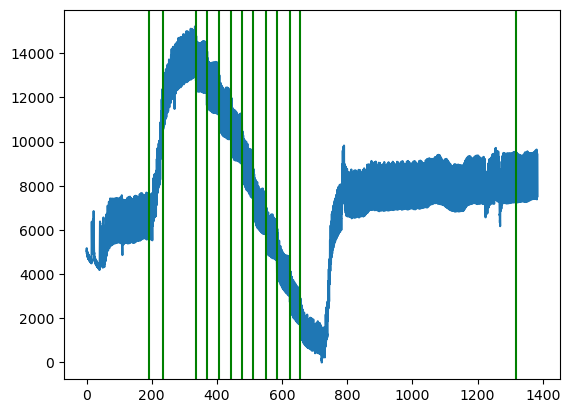

In [10]:
pprint(measurement.events)

plt.plot(measurement.time, measurement.framesets["raw"].global_impedance)
for event in measurement.events:
    plt.axvline(measurement.time[event.index], color="g")

When slicing a sequence, the list of events is also sliced and reindexed, so only events occurring during a sequence are available.

In [11]:
pprint(measurement[6000:8000].events)

[Event(index=713, text='peep 26'), Event(index=1379, text='peep 24')]


## End of inspiration and end of expiration

Dräger EIT files have "minmax" indicators indicating the start and end of breaths. 
They are loaded in the `phases` attribute.
The reliability of these indicators is limited.

[MinValue(index=14),
 MaxValue(index=28),
 MinValue(index=51),
 MaxValue(index=66),
 MinValue(index=89),
 MaxValue(index=102),
 MinValue(index=125),
 MaxValue(index=141),
 MinValue(index=164),
 MaxValue(index=178),
 MinValue(index=200),
 MaxValue(index=216),
 MinValue(index=240),
 MaxValue(index=253),
 MinValue(index=275),
 MaxValue(index=291),
 MinValue(index=311),
 MaxValue(index=328),
 MinValue(index=351),
 MaxValue(index=365),
 MinValue(index=387),
 MaxValue(index=403)]


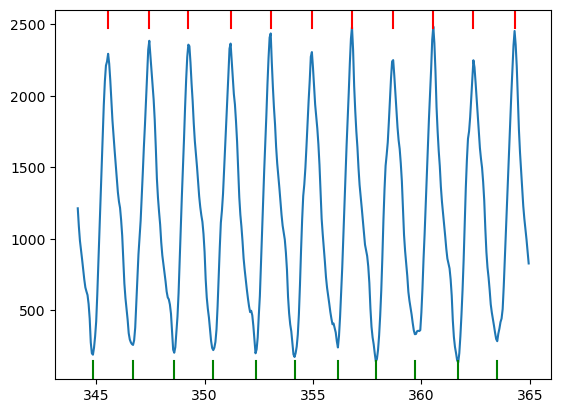

In [13]:
from eitprocessing.binreader import MaxValue, MinValue

pprint(short_section.phases)

plt.plot(short_section.time, short_section.framesets["bc"].global_impedance)

for indicator in filter(lambda x: isinstance(x, MaxValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.95, 1, color="r")

for indicator in filter(lambda x: isinstance(x, MinValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.0, 0.05, color="g")

## Accessing and plotting single frames

[Text(0.5, 1.0, 'End-inspiration')]

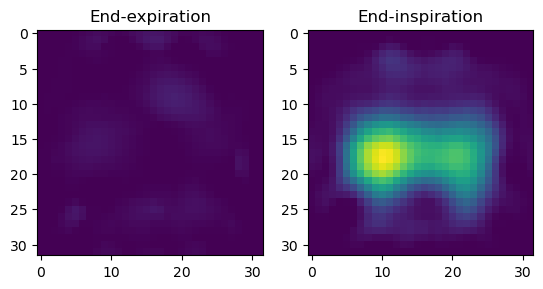

In [14]:
# Select the first MinValue and first MaxValue objects
min_value = next(filter(lambda x: isinstance(x, MinValue), short_section.phases))
max_value = next(filter(lambda x: isinstance(x, MaxValue), short_section.phases))

# Select the pixel data for the selected frames
min_data = short_section.framesets["bc"].pixel_values[min_value.index, :, :]
max_data = short_section.framesets["bc"].pixel_values[max_value.index, :, :]

# Get overall minimum and maximum values
vmin = np.min([min_data, max_data])
vmax = np.max([min_data, max_data])

# Create subplots
fig, ax = plt.subplots(1, 2)

# Create image
ax[0].imshow(min_data, vmin=vmin, vmax=vmax)
ax[1].imshow(max_data, vmin=vmin, vmax=vmax)

ax[0].set(title="End-expiration")
ax[1].set(title="End-inspiration")

## Animating frameset

In [15]:
short_section.framesets["bc"].animate()

  0%|          | 0/417 [00:00<?, ?it/s]

## Simple filtering

In [16]:
from scipy import signal
from eitprocessing.binreader import Frameset

filter_ = signal.butter(5, 40 / 60, "lowpass", fs=20, output="sos")
filtered_pixel_values = signal.sosfiltfilt(filter_, short_section.framesets["raw"].pixel_values, axis=0)

short_section.framesets["lp-filtered"] = Frameset(
    name="lp-filtered",
    description="lowpass filtered",
    params={"filter": [{"type": "butterworth_lowpass", "cutoff": 40 / 60}]},
    pixel_values=filtered_pixel_values,
)

plt.plot(short_section.time, short_section.framesets["raw"].global_impedance, label="raw")
plt.plot(short_section.time, short_section.framesets["lp-filtered"].global_impedance, label="low-pass filtered")
plt.legend()